# 06 - EDA Supervised Learining Model

On the previous Notebook I created a class to transform the time series to supervised learning dataset by applying methods such as split, expnading or rolling window to create new colums.

The method is available in mytransformer file.

The Custom Transformer can be set in a Pipeline as preprocessing step. The transformer accepts a dictionary as entry parameter to indicate which transformation to apply. This will be useful in GridSearch implementation for which I will be able to explore different combinations of tranformations.

The target of this NoteBook is to explore the final_timeserie dataset which contains only numerical value and make exploratory data analysis:

- control data types and checking missing values
- analyse data by cluster (performances, flows, marketing, research)
- <b>prototype 3-4 configuration file for the transformer (create config_x.json file) which will be included in the Pipeline as parameter</b>

## SweetViz

I work with sweetviz librairie which provides good method to explore and plot about the data in my source file.
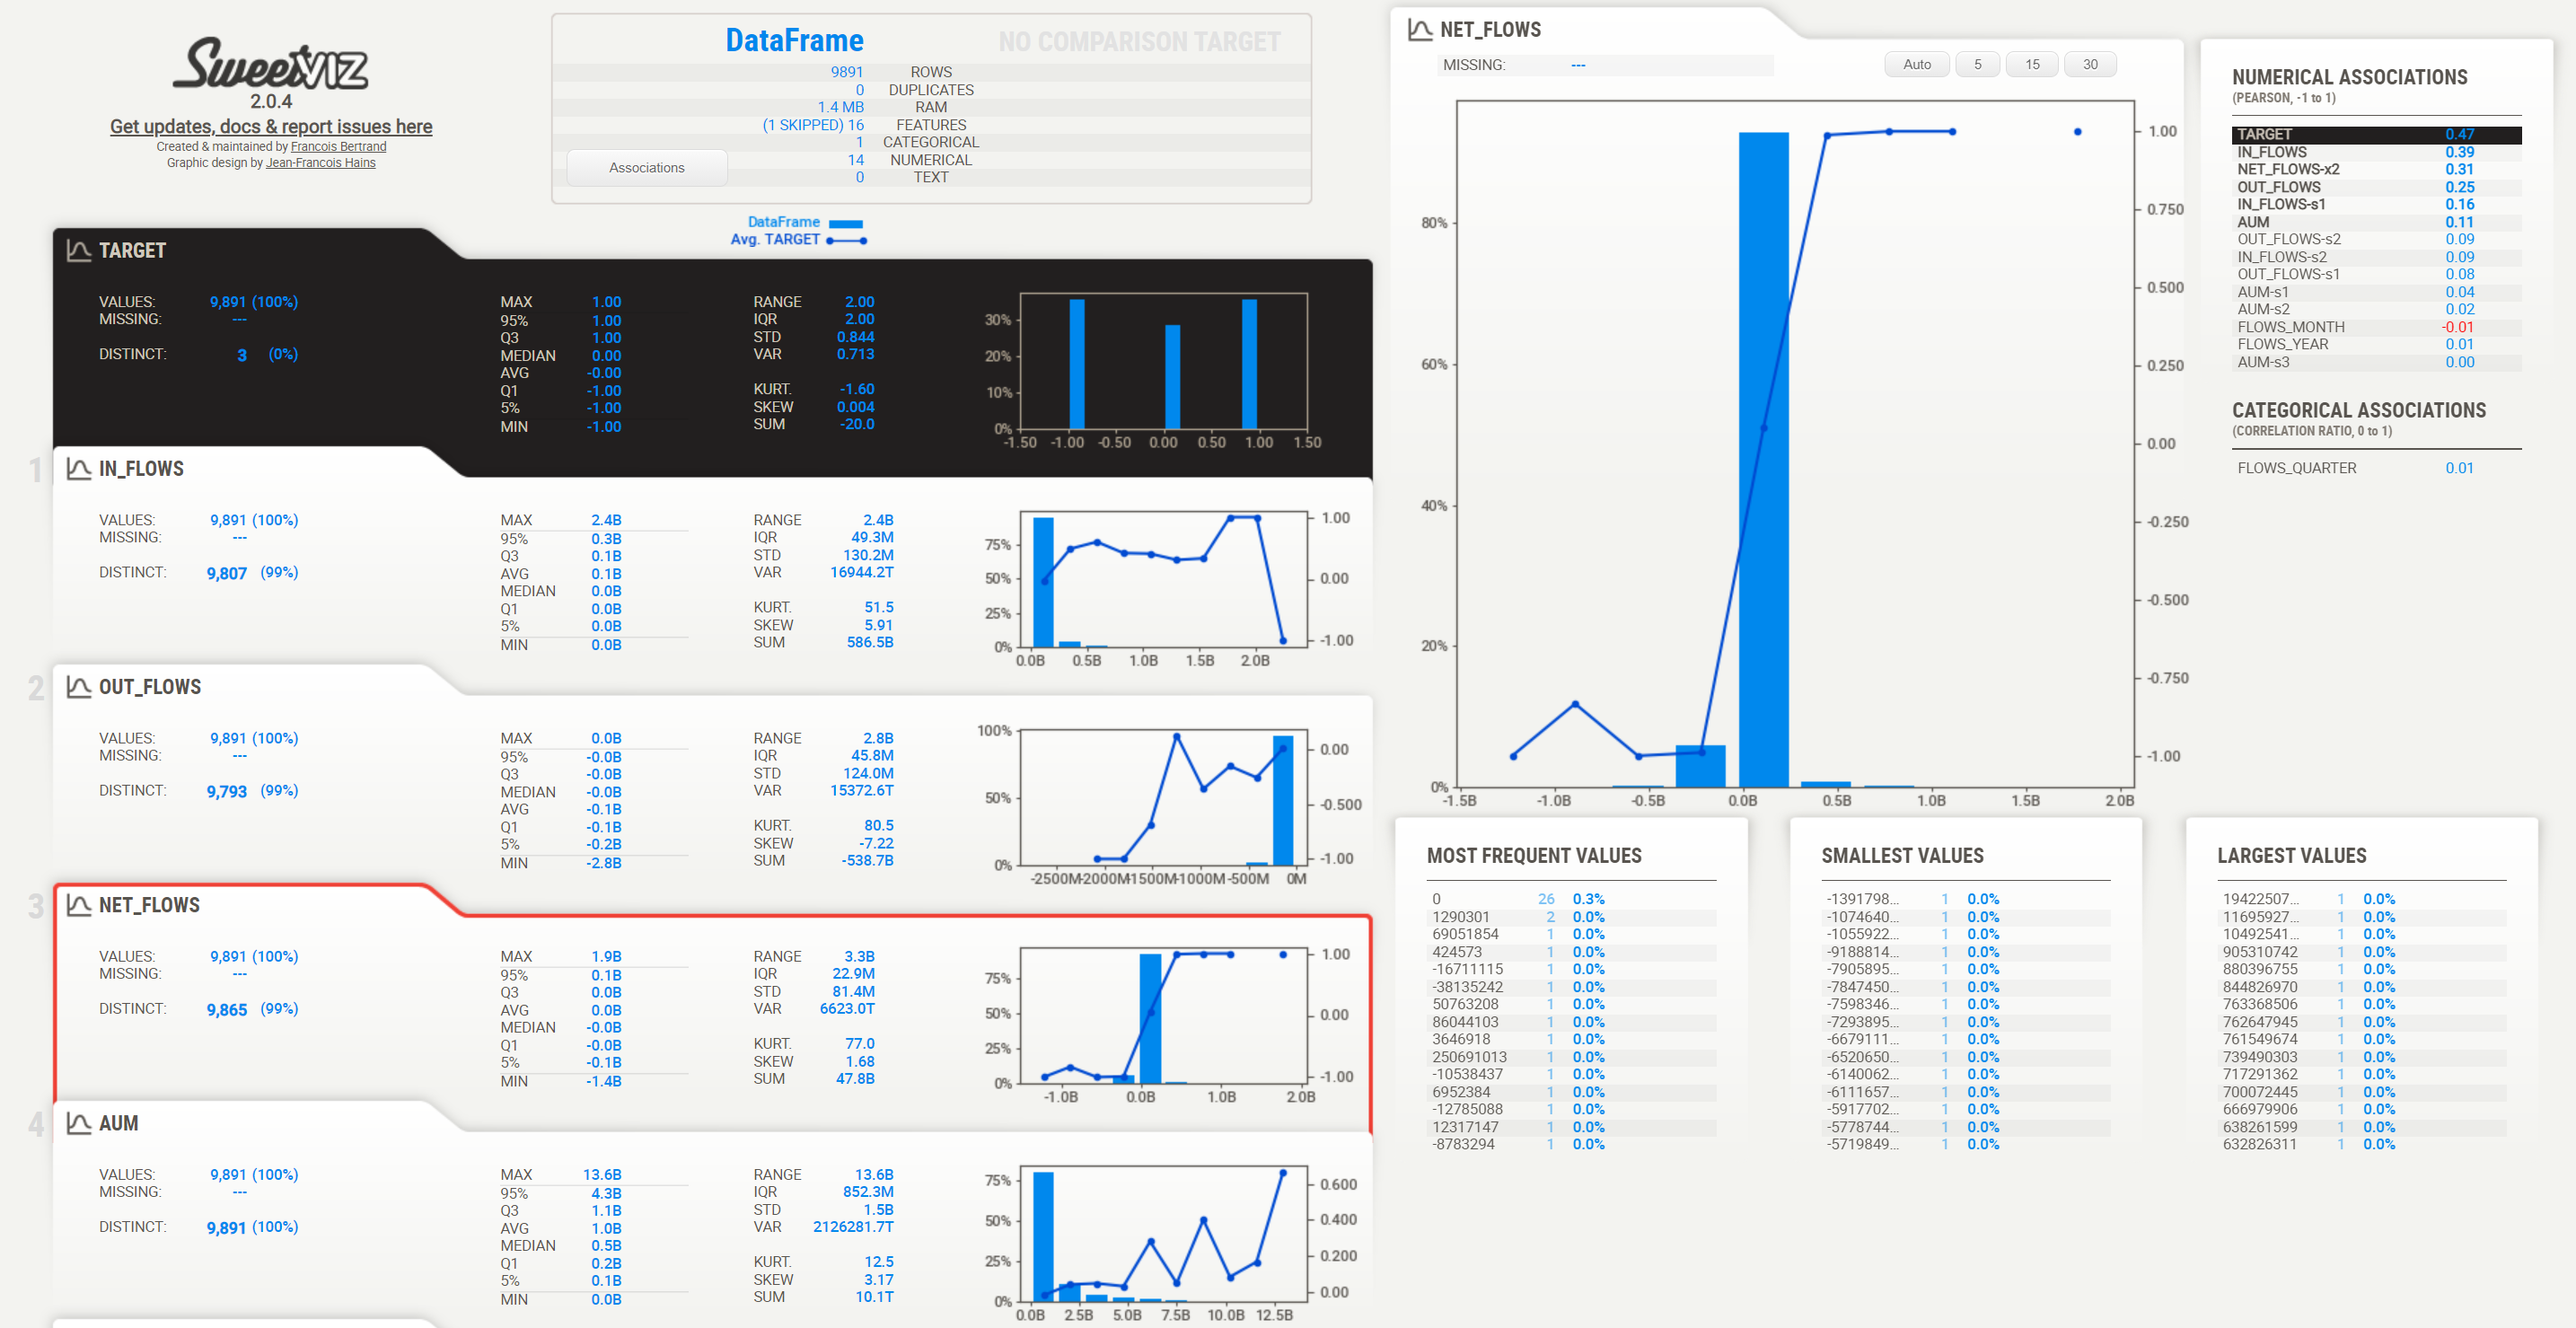

The picture below shows report from sweetviz and information I can collect from it such as
- target (balanced or imbalanced)
- missing data (none in my sample)
- association
- dataset summary (numerical, categorical)

## Configuration file for the custom transformer
The configuration file for my custom transformer is a list of dictionary which must contain:
- list of feature
- method to apply (shit, expanding, rolling, ...)
- period to compute
- keep or drop the original column

The Custom Transformer take another parameter to interpolate the result. This is useful if I want to use it in a pipeline because sklearn doesn't accept null value but when shifting or applying such method the result dataset contains NaN value. I decided to use interpolate (<i>after making some test by dropping rows or keeping rows with interpolate method that gave me very small differencies</i>).

### Configuration files pattern


#### 1. Focus on performances & flows
Apply the transformation to the subset of flows and performances features and keeping other features (markteting, research, ..) as is.

#### 2. Focus on marketing features
Apply transformation to this subset of data and keeping other data as is. I will skew some features.

#### 3. Full transformation
Apply transformation to most of the features.

For each configuration file I will apply method suc as Feature Selection or Dimensionality Reducation after the custom transformation.

# Import useful librairies

- my personal transformer is loaded as myt from mytransformer

I work with sweetviz and implement logging actions with logging librairies

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import OrdinalEncoder

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import logging
from datetime import datetime
from datetime import timedelta

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns

import json
from shutil import copyfile
import os

import tqdm

In [2]:
import mytransformer as myt

In [3]:
# create folder for log and sweetviz if not exists
if not os.path.exists('logs'):
    os.makedirs('logs')
    
import os
if not os.path.exists('sweetviz'):
    os.makedirs('sweetviz')

In [4]:
# create the log for this Notebook
now = datetime.now()
filename = 'logs/06-EDA-SL-' + now.strftime("%m%d%Y") + '.log'

logging.basicConfig(filename=filename ,format='%(asctime)s | %(levelname)s: %(message)s', level=20)
logging.info('')
logging.info('***************************************************************************************************')
logging.info('***                                                                                             ***')
logging.info('***   NEW RUN                                                                                   ***')
logging.info('***                                                                                             ***')
logging.info('***************************************************************************************************')

logging.info('I start to run your Notebook ! -- Good Luck :-) It is:  '+ now.strftime("%m/%d/%Y, %H:%M:%S"))


In [5]:
# constant variable with file path
# folder = '../../data source/_anonymized/'

# declare some constants
folder = '_anonymized/'

In [6]:
# read the cleaned csv files
# rty to parse dates
df = pd.read_csv(folder + 'final_timeseries.csv')
try:
    df.drop('Unnamed: 0', axis=1, inplace=True)
except:
    logging.warning('Unnamed: 0 not existing in this file.')
    
logging.info('{} rows and {} columns read in the CSV file'.format(df.shape[0], df.shape[1]))
df.shape

(9891, 61)

# General view of the dataset

I create a sweetviz report with the entry dataset (final_timeseries.csv). This will give some highlights on the data, their relations and associations and data distribution. Based on that I will decide more data exploration.

In [7]:
# no need to include the SRC_UID which is a foreign key and define the traget 
feature_config = sv.FeatureConfig(skip="SRC_UID", force_num=["TARGET"])
my_report = sv.analyze(df, feat_cfg=feature_config, target_feat='TARGET')
my_report.show_html(open_browser=False) 


# save the report on another name
copyfile('SWEETVIZ_REPORT.html','sweetviz/sw_full_report_before_engineering.html')


Report SWEETVIZ_REPORT.html was generated.


'sweetviz/sw_full_report_before_engineering.html'

The report shows the number of rows, if duplicates exist, the memory usage and deatil about feature. I can check if text column still exists and solve it as I want only numerical or categorical feature for the EDA.
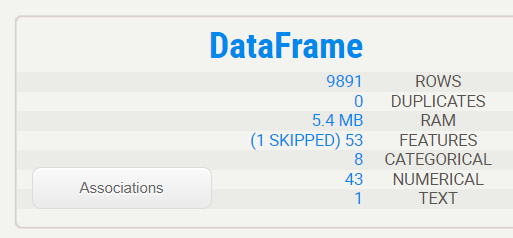


In [8]:
# check if text column still exists
col_text = df.select_dtypes(include='object').columns.tolist()
col_text

['EOM', 'DATE_SHARE']

In [9]:
# transform object column
try:
    # I don't need the EOM because I transformed this columns in Mnth, Year and Quarter
    df.drop('EOM', axis=1, inplace=True)
    # I don't need the DATE_SHARE because I calculated the fund age
    df.drop('DATE_SHARE', axis=1, inplace=True)
except:
    logging.warning('unable to transform EOM and DATE_SHARE to datetime object')
    
# check if text column still exists
col_text = df.select_dtypes(include='object').columns.tolist()
col_text

[]

# Analysing the features
Looking the type of data. I will decide some data clusters such as all FLOWS columns, all PERFORMANCES columns, all MARKETING columns and other CHARACTERISTICS or RESEARCH columns.

In [10]:
df.columns

Index(['SRC_UID', 'IS_STRATEGIC', 'ADMINSTRATION_FEES', 'MANAGEMENT_FEES',
       'MULTI_MANAGER_STRUCTURE', 'EXPERIENCE', 'SOFTCLOSING', 'CNT_SHARE',
       'QUANTITY', 'IN_FLOWS', 'OUT_FLOWS', 'NET_FLOWS', 'AUM',
       'BENCH_PERF_1_MONTH', 'BENCH_PERF_1_YEAR', 'BENCH_PERF_3_MONTH',
       'BENCH_PERF_6_MONTH', 'BENCH_VOL_1_MONTH', 'BENCH_VOL_3_MONTH',
       'BENCH_VOL_6_MONTH', 'BENCH_VOLATILITY_1_YEAR', 'NAV_PERF_1_MONTH',
       'NAV_PERF_1_YEAR', 'NAV_PERF_3_MONTH', 'NAV_PERF_6_MONTH',
       'NAV_VOL_1_MONTH', 'NAV_VOL_3_MONTH', 'NAV_VOL_6_MONTH',
       'NAV_VOLATILITY_1_YEAR', 'BENCH_VOL_SINCE_INCEPT',
       'NAV_PERF_COMPOUND_CREATION', 'NAV_VOL_SINCE_INCEPT', 'FUND_SIZE',
       'SUB_FUNDS_SHARE_PARTS', 'SUB_FUNDS_SHARE_SIZE_SF_CCY',
       'DOWNLOADED_DOCUMENTS', 'WEIGHTED', 'PSU_SCORE', 'POSITIVE_RFP',
       'EVENT_IMPACT', 'COMPUTED_FLOWS', 'CHECKED', 'DIFF_FLOWS', 'THRESHOLD',
       'TARGET', 'RISK_LEVEL_VALUE', 'PRODUCT_STRATEGY', 'ASSET_NAME',
       'FUND_NAME', 

In [11]:
# columns which describe the fund
cols_characteristics = ['SRC_UID','IS_STRATEGIC','MULTI_MANAGER_STRUCTURE','RISK_LEVEL_VALUE',
       'PRODUCT_STRATEGY', 'ASSET_NAME', 'FUND_NAME', 'STRATEGY_CAPABILITY', 'CNT_SHARE',
 'SOFTCLOSING', 'ADMINSTRATION_FEES', 'MANAGEMENT_FEES']

# columns which describe the flows and asset under management
cols_flows = ['QUANTITY', 'IN_FLOWS', 'OUT_FLOWS',
       'NET_FLOWS', 'AUM', 'FUND_SIZE',
       'SUB_FUNDS_SHARE_PARTS', 'SUB_FUNDS_SHARE_SIZE_SF_CCY', 'THRESHOLD']

# columns which describe the performance <nd volatility for NAV & BENCHMARK
cols_performances = ['BENCH_PERF_1_MONTH', 'BENCH_PERF_1_YEAR',
       'BENCH_PERF_3_MONTH', 'BENCH_PERF_6_MONTH', 'BENCH_VOL_1_MONTH',
       'BENCH_VOL_3_MONTH', 'BENCH_VOL_6_MONTH', 'BENCH_VOLATILITY_1_YEAR',
       'NAV_PERF_1_MONTH', 'NAV_PERF_1_YEAR', 'NAV_PERF_3_MONTH',
       'NAV_PERF_6_MONTH', 'NAV_VOL_1_MONTH', 'NAV_VOL_3_MONTH',
       'NAV_VOL_6_MONTH', 'NAV_VOLATILITY_1_YEAR', 'BENCH_VOL_SINCE_INCEPT',
       'NAV_PERF_COMPOUND_CREATION', 'NAV_VOL_SINCE_INCEPT']

# columns which get Marketing information in the observation
cols_marketing = ['DOWNLOADED_DOCUMENTS','POSITIVE_RFP',
       'EVENT_IMPACT']

# columns which define the timeline (when the observation occurs)
cols_timeline = ['FLOWS_MONTH', 'FLOWS_YEAR', 'FLOWS_QUARTER', 'FUND_AGE']

# columns which describe the Macro Research indicator
cols_research = ['WEIGHTED', 'PSU_SCORE','COUNTRY', 'PSU']

all_cols = cols_characteristics + cols_flows + cols_performances + cols_marketing + cols_timeline + cols_research

diff=list(set(df.columns) - set(all_cols))
logging.info('After splitting the columns the difference will be my TARGET feature: {}'.format(diff))
diff

['CHECKED',
 'DIFF_FLOWS',
 'EXPERIENCE',
 'DOWNLOADED_DOCUMENTS_BIN',
 'FUND_AGE_BIN',
 'EXPERIENCE_BIN',
 'TARGET',
 'COMPUTED_FLOWS']

# FLOWS features analysis
The flows features contains in flow and out flow and net flows. Some net flows might be not exactly the sum from (in - out) because some movments are not logged in this system such as "seed" money (inital investment of the management company). A portfolio cannot start from scratch and some moneys are initially invested.

The <b>quantity</b> is the volume of shares exchanded during the period.

AUM & Fund Size are similar metric and I will check if both must be kept.

Sub funds share represents the entry "door" in a portfolio (mutual funds). For example, to invest in a Thematic Funds such as the Water Funds you can enter in USD, CHF or EUR. Each currency is allocated to a specific sub fund share. I will see if this features is relevant with the target with a correlation matrix.

At the opposite of a stock (securities) you can hold part of a share. If you invest 1000CHF and the daily price is 145CHF you will have 6.89 shares

As explain in the previous Notebook, the <b>thresold</b> is a measure of the net flows relative to the AUM. If the value is above a threshold we can consider the flows having an impact. It has been used to determine the target [-1, 0, +1].

For all features, I will have a look of potential outliers.

In [12]:
pd.set_option("precision", 2)
df[cols_flows].describe()

,QUANTITY,IN_FLOWS,OUT_FLOWS,NET_FLOWS,AUM,FUND_SIZE,SUB_FUNDS_SHARE_PARTS,SUB_FUNDS_SHARE_SIZE_SF_CCY,THRESHOLD
count,9.89e+03,9.89e+03,9.89e+03,9.89e+03,9.89e+03,9.89e+03,9.89e+03,9.89e+03,9.89e+03
mean,4.99e+06,5.93e+07,-5.45e+07,4.83e+06,1.02e+09,2.93e+09,5.46e+05,2.35e+08,1.17e-03
std,7.46e+06,1.30e+08,1.24e+08,8.14e+07,1.46e+09,1.04e+10,7.44e+05,9.12e+08,4.70e-01
min,1.00e+02,0.00e+00,-2.77e+09,-1.39e+09,1.53e+04,7.64e+04,2.53e+02,2.55e+04,-4.56e+01
25%,7.53e+05,5.46e+06,-5.16e+07,-1.03e+07,2.45e+08,2.39e+08,1.12e+05,3.07e+07,-2.08e-02
50%,2.20e+06,1.76e+07,-1.74e+07,-2.15e+04,5.22e+08,5.35e+08,2.58e+05,6.82e+07,-1.03e-04
75%,5.97e+06,5.47e+07,-5.85e+06,1.25e+07,1.10e+09,1.25e+09,6.71e+05,1.58e+08,2.31e-02
max,6.84e+07,2.36e+09,0.00e+00,1.94e+09,1.36e+10,1.34e+11,5.96e+06,1.70e+10,1.08e+00


In [13]:
df[cols_flows].corr()

,QUANTITY,IN_FLOWS,OUT_FLOWS,NET_FLOWS,AUM,FUND_SIZE,SUB_FUNDS_SHARE_PARTS,SUB_FUNDS_SHARE_SIZE_SF_CCY,THRESHOLD
QUANTITY,1.00e+00,0.45,-0.41,1.07e-01,8.68e-01,3.40e-01,6.41e-01,8.19e-02,6.98e-03
IN_FLOWS,4.55e-01,1.00,-0.80,3.87e-01,6.24e-01,1.68e-01,4.21e-01,9.48e-02,3.82e-02
OUT_FLOWS,-4.07e-01,-0.80,1.00,2.50e-01,-5.86e-01,-1.80e-01,-3.91e-01,-1.00e-01,3.21e-02
NET_FLOWS,1.07e-01,0.39,0.25,1.00e+00,1.05e-01,-5.61e-03,7.84e-02,-9.58e-04,1.10e-01
AUM,8.68e-01,0.62,-0.59,1.05e-01,1.00e+00,3.24e-01,4.94e-01,7.62e-02,5.30e-03
FUND_SIZE,3.40e-01,0.17,-0.18,-5.61e-03,3.24e-01,1.00e+00,1.25e-01,7.33e-01,-8.12e-04
SUB_FUNDS_SHARE_PARTS,6.41e-01,0.42,-0.39,7.84e-02,4.94e-01,1.25e-01,1.00e+00,1.00e-01,7.21e-03
SUB_FUNDS_SHARE_SIZE_SF_CCY,8.19e-02,0.09,-0.10,-9.58e-04,7.62e-02,7.33e-01,1.00e-01,1.00e+00,-9.36e-04
THRESHOLD,6.98e-03,0.04,0.03,1.10e-01,5.30e-03,-8.12e-04,7.21e-03,-9.36e-04,1.00e+00


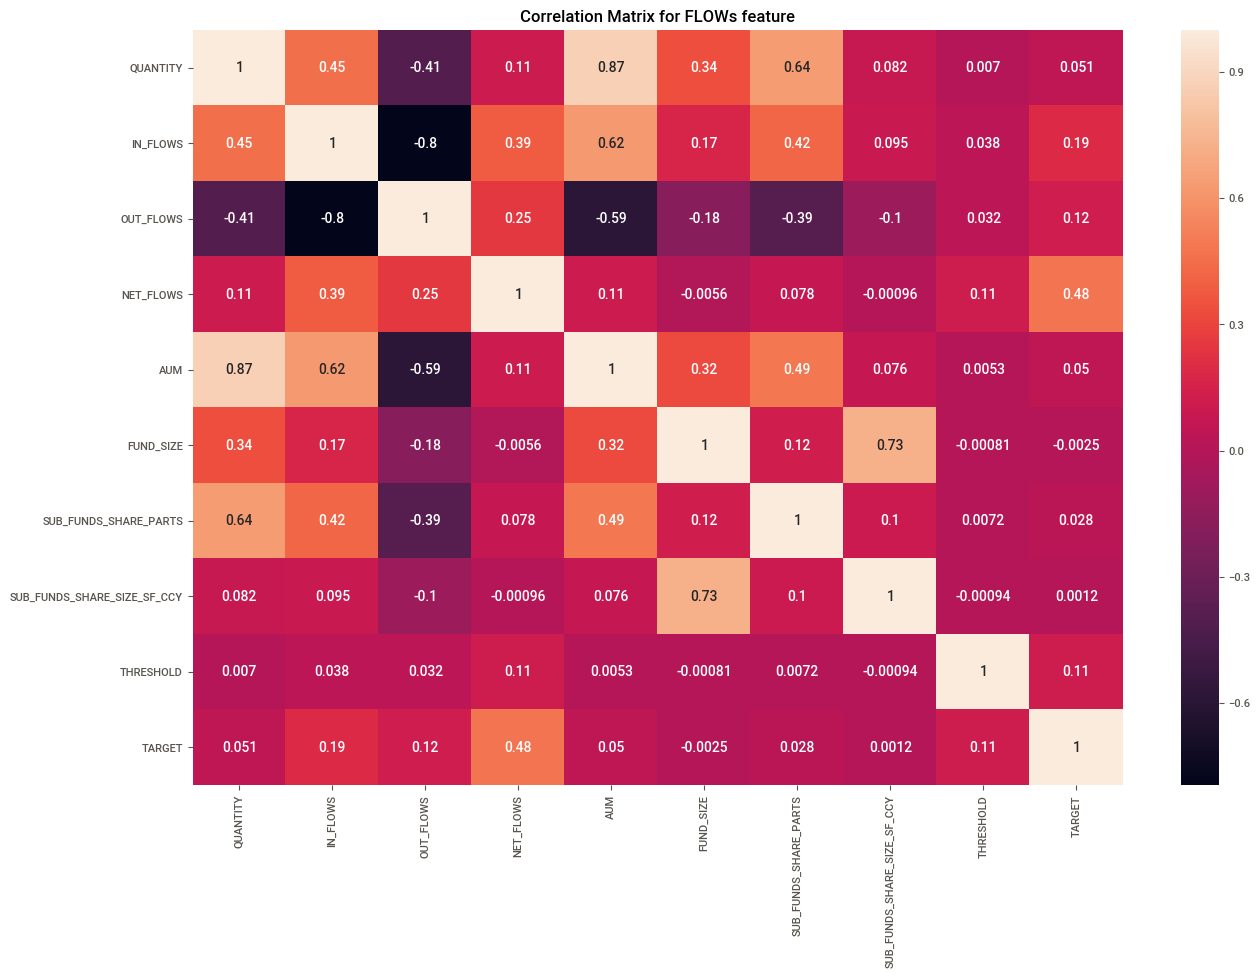

In [14]:
plt.figure(figsize=(15,10))
cols_flows_target = cols_flows.copy()
cols_flows_target.append('TARGET')
sns.heatmap(df[cols_flows_target].corr(), annot=True)
plt.title('Correlation Matrix for FLOWs feature')
plt.show()

I decided to remove <b>correlated</b> value:
- Quantity has a corr close to 0.87 with AUM, I keep AUM
- In flows and Out flows are negatively correlated wihch is logical; they are correlated with AUN but I keep all
- Sub_funds_share part is correlated with Quantity, I will not keep this feature
- Sub_funds_share_Size is correlated with Fund Size, I will not keep it

I can drop from my dataset ['QUANTITY','SUB_FUNDS_SHARE_PARTS', 'SUB_FUNDS_SHARE_SIZE_SF_CCY']

In [15]:
try:
    cols_flows.remove('SUB_FUNDS_SHARE_PARTS')
    cols_flows.remove('SUB_FUNDS_SHARE_SIZE_SF_CCY')
    cols_flows.remove('QUANTITY')
    logging.inf('QUANTITY, SUB_FUNDS_SHARE_PARTS and SUB_FUNDS_SHARE_SIZE_SF_CCY dropped from the dataset because of correlation')
except:
    logging.warning('Unable to drop flows columns')

In [16]:
cols_flows

['IN_FLOWS', 'OUT_FLOWS', 'NET_FLOWS', 'AUM', 'FUND_SIZE', 'THRESHOLD']

## Analyzing correlation between actual flows and previous flows
To do that I will apply transformation (using the mytransformer librarie) and plot correlation.
I will start with Net Flow columns and look how it's correlated with 3,4 or 6 months in the past.

In [17]:
# create a temporary dataset
temp_cols_flows = cols_flows.copy()
temp_cols_flows.append('TARGET')
temp_cols_flows.append('SRC_UID')
temp_cols_flows.append('FLOWS_YEAR')
temp_cols_flows.append('FLOWS_MONTH')
df_flows = df[temp_cols_flows].copy()
df_flows.sort_values(['SRC_UID','FLOWS_YEAR','FLOWS_MONTH'], inplace=True)
df_flows.head()

,IN_FLOWS,OUT_FLOWS,NET_FLOWS,AUM,FUND_SIZE,THRESHOLD,TARGET,SRC_UID,FLOWS_YEAR,FLOWS_MONTH
0,69669121,-201496427,-131827306,706167185,9.57e+08,-0.19,-1,206670688,2010,1
1,89408248,-74310603,15097645,721513696,9.87e+08,0.02,1,206670688,2010,2
2,68084125,-163602809,-95518684,626071563,8.80e+08,-0.15,-1,206670688,2010,3
3,104779215,-87141120,17638095,643746057,8.26e+08,0.03,1,206670688,2010,4
4,65517596,-132116073,-66598477,577294330,6.99e+08,-0.12,-1,206670688,2010,5


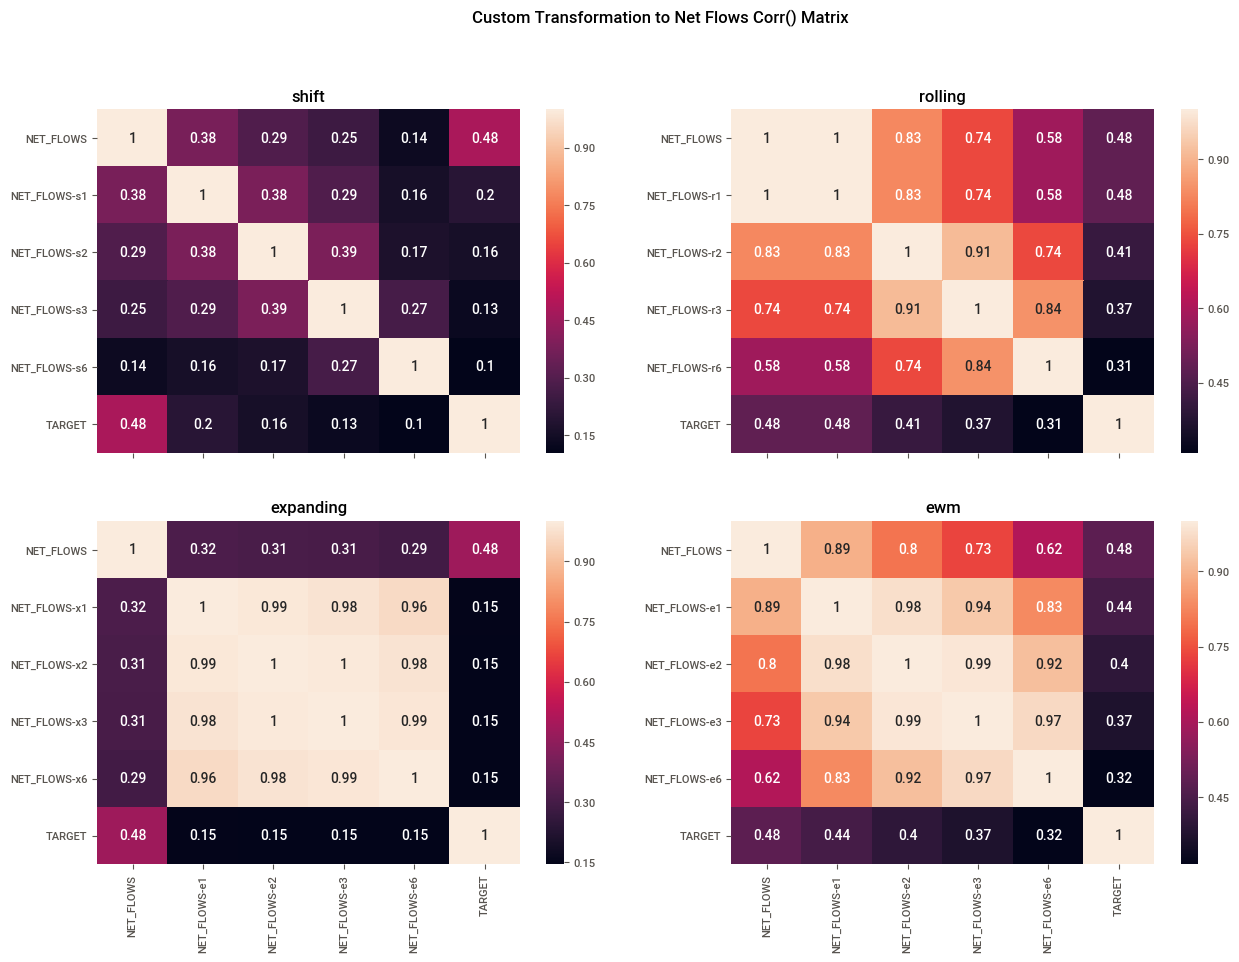

In [18]:
transformer = ['shift','rolling','expanding','ewm']
fig, axs = plt.subplots(2, 2, figsize=(15,10), sharex=True)
fig.suptitle('Custom Transformation to Net Flows Corr() Matrix')
xy = [[0,0],[0,1],[1,0],[1,1]]
i=0

for method in transformer:

    # Create X and y
    X = df_flows.drop('TARGET', axis=1)
    y = df_flows.TARGET

    # define columns which will passed to transformer for the grouping (brk)
    # when applying method such as shift or expanding, I want to maintain the
    # fund grouping (or other attribute to set in brk).
    brk='SRC_UID'

    # create a configuration dictionary for the transformer
    trans = []
    dico= {}
    dico['cols'] = ['NET_FLOWS']
    dico['method'] = method
    dico['period'] = [1,2,3,6]
    dico['original'] = True
    trans.append(dico)

    # create the steps and the transformation Pipeline
    steps = [('ts_2_supervised',myt.TS2Supervised(transformation=trans, breakdown=brk
                                              , verbose=False, interpolation=True))]
    transformation_pipeline = Pipeline(steps)

    test_transformed_pipeline = transformation_pipeline.fit_transform(X, y)
    test_transformed_pipeline=test_transformed_pipeline.merge(df['TARGET'], left_index=True, right_index=True)

    net_flows_cols = [x for x in test_transformed_pipeline.columns if 'NET_FLOWS' in x]
    net_flows_cols.append('TARGET')

    #plt.figure(figsize=(4,4))

    sns.heatmap(data=test_transformed_pipeline[net_flows_cols].corr(), annot=True, ax=axs[xy[i][0],xy[i][1]])
    axs[xy[i][0],xy[i][1]].set_title(method)
    i=i+1



plt.show();

## Observations
The chart shows correlations between transformed features (NET FLOWS) and TARGET We can observe that applying "rolling" or "ewm" method gives more correlation with the target variable. I will used them in configuration files. As far as we go (in my example from 1--6, as lower the correlation is but ~0.36 with a "6" parameter.

### EWM
From pandas documentation.
"<i>An exponentially weighted window is similar to an expanding window but with each prior point being exponentially weighted down relative to the current point.</i>"

# PERFORMANCES features analysis


In [19]:
# define a list pf PERF BENCH
cols_perf_bench = ['BENCH_PERF_1_YEAR','BENCH_PERF_6_MONTH','BENCH_PERF_3_MONTH','BENCH_PERF_1_MONTH']
selection=df.loc[0,cols_perf_bench]*100
selection

BENCH_PERF_1_YEAR      0.75
BENCH_PERF_6_MONTH     0.17
BENCH_PERF_3_MONTH    0.057
BENCH_PERF_1_MONTH    0.018
Name: 0, dtype: object

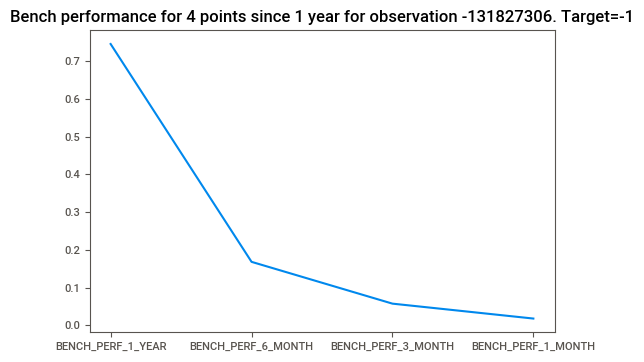

In [20]:
# plot this observation
plt.plot(selection)
plt.title('Bench performance for 4 points since 1 year for observation {}. Target={}'.format(df.loc[0,'NET_FLOWS'],df.loc[0,'TARGET']))
plt.show();

This <b>observed</b> NET FLOWS which gave a specific target of (-1) is clearly negative. The data transformation is to compute this <b>trend</b>. To do that, I will compute the slope using the polyfit method from numpy.

In [21]:
data = selection.tolist()
x = np.arange(0,len(data))
y=np.array(data)
z=np.polyfit(x,y,1)
z

array([-0.229367,  0.591188])

I can observe a negative trend of -0.23 units per interval (interval goes from 1year to 6 months, to 3 months and 1 month). <i>We do not store each month performance in our Datwarehouse, one improvment would be to take each price for past 12 months and compute values before loading but I wanted to load data directly available</i>.

Now I can plot the trend line on the chart.

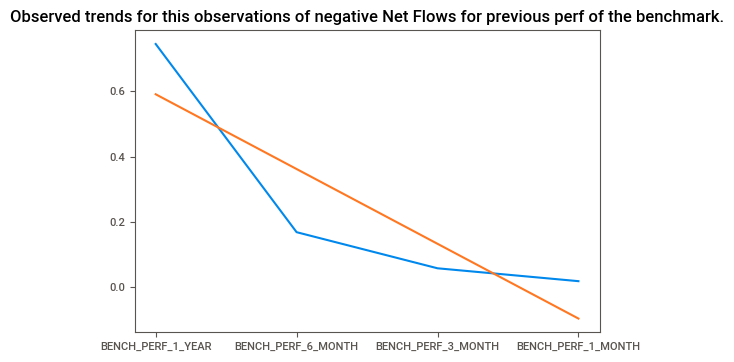

In [22]:
plt.plot(selection)
plt.plot([z[0]*x + z[1] for x in range(len(selection))])
plt.title('Observed trends for this observations of negative Net Flows for previous perf of the benchmark.')
plt.show();

In [23]:
cols_performances

['BENCH_PERF_1_MONTH',
 'BENCH_PERF_1_YEAR',
 'BENCH_PERF_3_MONTH',
 'BENCH_PERF_6_MONTH',
 'BENCH_VOL_1_MONTH',
 'BENCH_VOL_3_MONTH',
 'BENCH_VOL_6_MONTH',
 'BENCH_VOLATILITY_1_YEAR',
 'NAV_PERF_1_MONTH',
 'NAV_PERF_1_YEAR',
 'NAV_PERF_3_MONTH',
 'NAV_PERF_6_MONTH',
 'NAV_VOL_1_MONTH',
 'NAV_VOL_3_MONTH',
 'NAV_VOL_6_MONTH',
 'NAV_VOLATILITY_1_YEAR',
 'BENCH_VOL_SINCE_INCEPT',
 'NAV_PERF_COMPOUND_CREATION',
 'NAV_VOL_SINCE_INCEPT']

I have 4 groups of returns for which I ma going to compute the <b>slope</b> as explained below.
- benchmark performance (or indices)
- benchamrk volatility
- nav (net asset value) performance
- nav volatility

In [24]:
# define the function
def compute_slope(data):
    '''
    receive data which is a list of 4 values
    and return the slope and the error rate after using the polyfit method
    I will temporary store the error rate to analyse it
    '''
    x = np.arange(0,len(data))
    y=np.array(data)

    z=np.polyfit(x,y,1)
    return z   

The next cell compute the slope for 4 values in each of BENCH, NAV Performance & Volatility.

In [25]:
df = df.copy()
with tqdm.tqdm(total=df.shape[0]) as pbar:  
    for idx, r in df.iterrows():
        # compute BENCH PERF
        p=df.loc[idx,['BENCH_PERF_1_YEAR','BENCH_PERF_6_MONTH','BENCH_PERF_3_MONTH','BENCH_PERF_1_MONTH']].values.tolist()
        s=compute_slope(p)
        df.loc[idx,'BENCH_PERF_SLOPE']=s[0]
        df.loc[idx,'BENCH_PERF_SLOPE_ERROR']=s[1]
        #logging.info('Benchmark performance slope computed')

        # compute BENCH VOL
        p=df.loc[idx,['BENCH_VOLATILITY_1_YEAR','BENCH_VOL_6_MONTH','BENCH_VOL_3_MONTH','BENCH_VOL_1_MONTH']].values.tolist()
        s=compute_slope(p)
        df.loc[idx,'BENCH_VOL_SLOPE']=s[0]
        df.loc[idx,'BENCH_VOL_SLOPE_ERROR']=s[1]
        #logging.info('Benchmark volatility slope computed')

        # compute NAV PERF
        p=df.loc[idx,['NAV_PERF_1_YEAR','NAV_PERF_6_MONTH','NAV_PERF_3_MONTH','NAV_PERF_1_MONTH']].values.tolist()
        s=compute_slope(p)
        df.loc[idx,'NAV_PERF_SLOPE']=s[0]
        df.loc[idx,'NAV_PERF_SLOPE_ERROR']=s[1]
        #logging.info('NAV performance slope computed')

        # compute NAV VOL
        p=df.loc[idx,['NAV_VOLATILITY_1_YEAR','NAV_VOL_6_MONTH','NAV_VOL_3_MONTH','NAV_VOL_1_MONTH']].values.tolist()
        s=compute_slope(p)
        df.loc[idx,'NAV_VOL_SLOPE']=s[0]
        df.loc[idx,'NAV_VOL_SLOPE_ERROR']=s[1]
        #logging.info('NAV volatility slope computed')
        
        pbar.update(1)
    

100%|█████████████████████████████████████████████████████████████████████████████| 9891/9891 [01:14<00:00, 133.13it/s]


In [26]:
cols_bench_perf = [x for x in df.columns if 'SLOPE' in x or 'ERROR' in x or 'TARGET' in x or 'SRC_UID' in x]

In [27]:
df[cols_bench_perf].head(8)

,SRC_UID,TARGET,BENCH_PERF_SLOPE,BENCH_PERF_SLOPE_ERROR,BENCH_VOL_SLOPE,BENCH_VOL_SLOPE_ERROR,NAV_PERF_SLOPE,NAV_PERF_SLOPE_ERROR,NAV_VOL_SLOPE,NAV_VOL_SLOPE_ERROR
0,206670688,-1,-2.29e-03,5.91e-03,-3.32e-05,1.71e-04,-1.93e-03,4.77e-03,-1.54e-04,6.94e-04
1,206670688,1,-1.88e-03,4.87e-03,-3.24e-05,1.59e-04,-1.65e-03,3.94e-03,-1.27e-04,6.52e-04
2,206670688,-1,-1.61e-03,4.22e-03,-3.38e-05,1.28e-04,-1.49e-03,3.63e-03,-1.06e-04,6.47e-04
3,206670688,1,-1.36e-03,3.62e-03,-2.22e-05,1.26e-04,-1.05e-03,2.52e-03,-8.16e-05,6.07e-04
4,206670688,-1,-1.12e-03,3.11e-03,-1.64e-05,1.12e-04,-7.43e-04,1.72e-03,-6.19e-05,6.10e-04
5,206670688,-1,-9.58e-04,2.84e-03,-1.07e-05,1.33e-04,-5.40e-04,1.31e-03,-3.98e-05,6.55e-04
6,206670688,-1,-8.76e-04,2.78e-03,1.68e-06,1.51e-04,-3.82e-04,1.58e-03,-2.38e-05,7.36e-04
7,206670688,1,-8.61e-04,2.85e-03,-8.68e-06,1.48e-04,-4.21e-04,1.80e-03,-5.95e-05,7.41e-04


In [28]:
# selection of columns to create a new sweetviz report
cols_bench_perf = [x for x in df.columns if 'BENCH' in x or 'NAV' in x]
cols_bench_perf.append('SRC_UID')
cols_bench_perf.append('TARGET')

# no need to include the SRC_UID which is a foreign key and define the traget 
feature_config = sv.FeatureConfig(skip="SRC_UID", force_num=["TARGET"])
my_report = sv.analyze(df[cols_bench_perf], feat_cfg=feature_config, target_feat='TARGET')
my_report.show_html(open_browser=False) 


Report SWEETVIZ_REPORT.html was generated.


In [29]:
# save the report on another name
copyfile('SWEETVIZ_REPORT.html','sweetviz/sw_bench_nav_transformation.html')

'sweetviz/sw_bench_nav_transformation.html'

### Plot new features
Now that I have created thos new features by computing a trend of past performance, I can plot a correlation matrix.

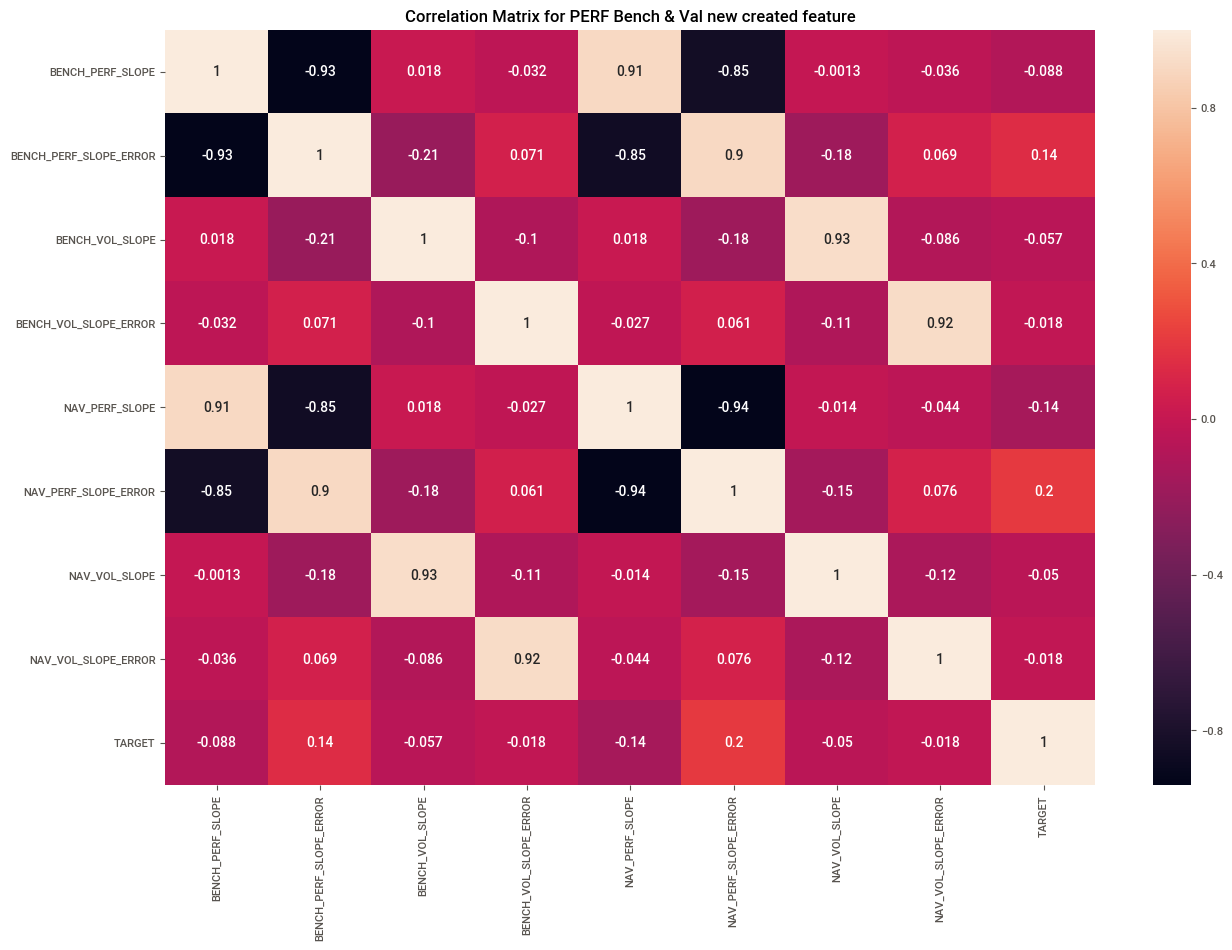

In [30]:
cols_bench_perf = [x for x in df.columns if 'ERROR' in x or 'SLOPE' in x]

plt.figure(figsize=(15,10))

cols_bench_perf.append('TARGET')
sns.heatmap(df[cols_bench_perf].corr(), annot=True)
plt.title('Correlation Matrix for PERF Bench & Val new created feature')
plt.show();

I won't work with ERROR features, I decided to keep the trend of past performance or volatility for features engineering with my custom transformer. I will apply different transformation and plot correlation matrix to decide which transformation will be applied in the pipeline with the configuration file.

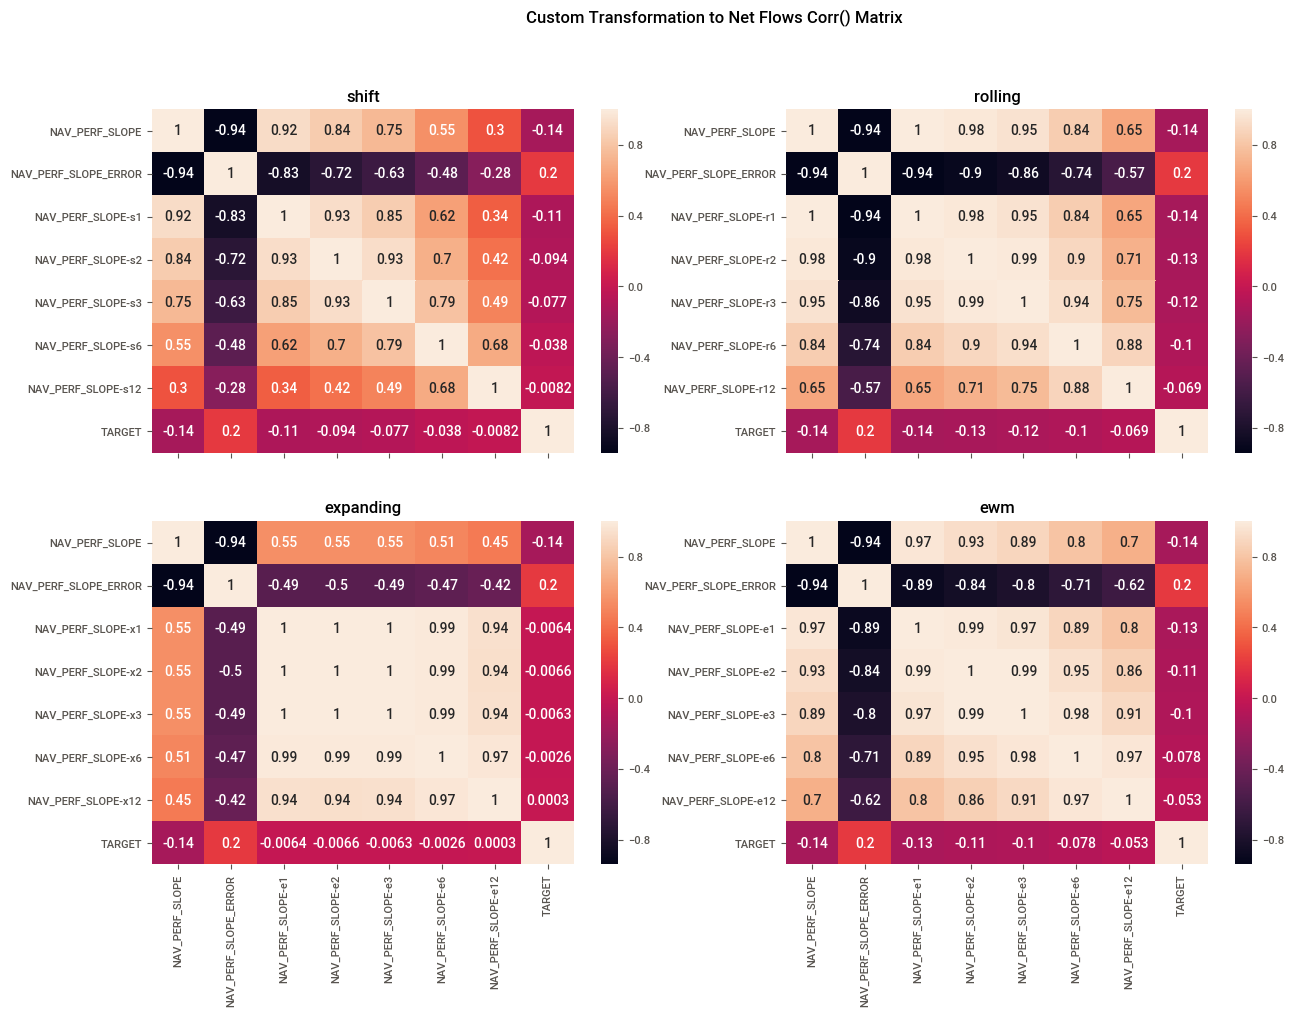

In [31]:
transformer = ['shift','rolling','expanding','ewm']
fig, axs = plt.subplots(2, 2, figsize=(15,10), sharex=True)
fig.suptitle('Custom Transformation to Net Flows Corr() Matrix')
xy = [[0,0],[0,1],[1,0],[1,1]]
i=0
df_flows=df.copy()
for method in transformer:

    # Create X and y
    X = df_flows.drop('TARGET', axis=1)
    y = df_flows.TARGET

    # define columns which will passed to transformer for the grouping (brk)
    # when applying method such as shift or expanding, I want to maintain the
    # fund grouping (or other attribute to set in brk).
    brk='SRC_UID'

    # create a configuration dictionary for the transformer
    trans = []
    dico= {}
    dico['cols'] = ['NAV_PERF_SLOPE']
    dico['method'] = method
    dico['period'] = [1,2,3,6,12]
    dico['original'] = True
    trans.append(dico)

    # create the steps and the transformation Pipeline
    steps = [('ts_2_supervised',myt.TS2Supervised(transformation=trans, breakdown=brk
                                              , verbose=False, interpolation=True))]
    transformation_pipeline = Pipeline(steps)

    test_transformed_pipeline = transformation_pipeline.fit_transform(X, y)
    test_transformed_pipeline=test_transformed_pipeline.merge(df['TARGET'], left_index=True, right_index=True)

    net_flows_cols = [x for x in test_transformed_pipeline.columns if 'NAV_PERF_SLOPE' in x]
    net_flows_cols.append('TARGET')

    #plt.figure(figsize=(4,4))

    sns.heatmap(data=test_transformed_pipeline[net_flows_cols].corr(), annot=True, ax=axs[xy[i][0],xy[i][1]])
    axs[xy[i][0],xy[i][1]].set_title(method)
    i=i+1



plt.show();

### New features with custom transformer

I will apply shift transformation for those new features in the configurations file. Correlation are more distributed.

# MARKETING Features
The next section will explore the marketing features of the dataset.

In [32]:
marketing = cols_marketing.copy()
marketing.append('TARGET')
marketing.append('SRC_UID')
# no need to include the SRC_UID which is a foreign key and define the traget 
feature_config = sv.FeatureConfig(skip="SRC_UID", force_num=["TARGET"])
my_report = sv.analyze(df[marketing], feat_cfg=feature_config, target_feat='TARGET')
my_report.show_html(open_browser=False) 

# copy the html file
copyfile('SWEETVIZ_REPORT.html','sweetviz/sw_marketing.html')


Report SWEETVIZ_REPORT.html was generated.


'sweetviz/sw_marketing.html'

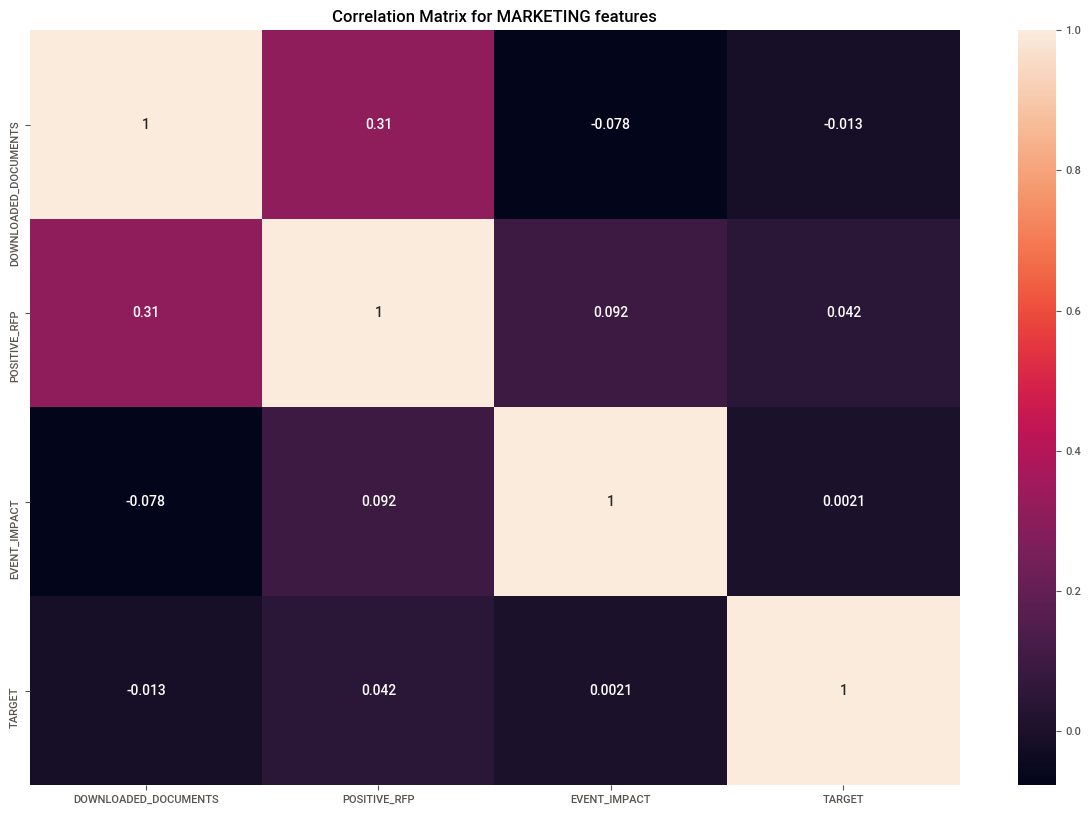

In [33]:
plot_marketing = cols_marketing.copy()

plt.figure(figsize=(15,10))

plot_marketing.append('TARGET')
sns.heatmap(df[plot_marketing].corr(), annot=True)
plt.title('Correlation Matrix for MARKETING features')
plt.show();

## Observation

There is low correlation between marketing features and TARGET variable. I can observe a correlation between the downloaded document and the RFP features. This feature will be added to the modeling process to check if it improve or not the score.

# PSU (MACRO RESEARCH)

In [34]:
psu = cols_research.copy()
psu.append('TARGET')
psu.append('SRC_UID')
# no need to include the SRC_UID which is a foreign key and define the traget 
feature_config = sv.FeatureConfig(skip="SRC_UID", force_num=["TARGET"])
my_report = sv.analyze(df[psu], feat_cfg=feature_config, target_feat='TARGET')
my_report.show_html(open_browser=False) 

# copy the html file
copyfile('SWEETVIZ_REPORT.html','sweetviz/sw_macro_research.html')


Report SWEETVIZ_REPORT.html was generated.


'sweetviz/sw_macro_research.html'

## PSU Score
It's an indicator given by the macro research team which prognose at 3-7 months (forecast) the trend for a region. The score was allocated to the fund depending on the country allocation (WEIGHT).

In [35]:
# statistic description of the PSU
df[psu].drop(['TARGET','SRC_UID'], axis=1).describe()

,WEIGHTED,PSU_SCORE,COUNTRY,PSU
count,9891.00,9891.00,9891.00,9891.00
mean,0.24,1.70,11.03,4.54
std,0.28,1.67,12.81,4.86
min,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00
50%,0.16,2.00,4.00,2.00
75%,0.43,3.00,29.00,11.00
max,1.03,5.00,32.00,12.00


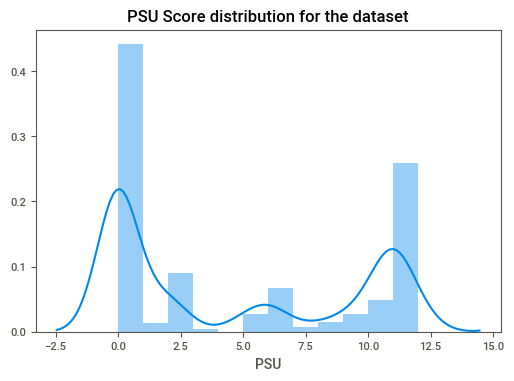

In [36]:
sns.distplot(df['PSU'])
plt.title('PSU Score distribution for the dataset')
plt.show()

### Observation on the PSU score
50% of the dataset entries has a score to 0. 20% of the set is 11. The data aren't well distributed. I am going to have a look by grouping the data by CAPABILITIES. 

In [37]:
df[['STRATEGY_CAPABILITY','PSU']].groupby('STRATEGY_CAPABILITY').agg({'PSU':['mean', 'max', 'min']})

PSU        
                      mean max min
STRATEGY_CAPABILITY               
0                     1.38   9   0
1                     8.24  11   0
2                     0.00   0   0
3                     4.40  11   0
4                     2.45  11   0
5                     4.98  11   0
6                     4.26  12   0
7                     4.00  11   0
8                     1.29  11   0
9                     0.00   0   0
10                    0.00   0   0
11                   10.93  11   5

I will transform the PSU with the Custom Transform and check how it react with TARGET NET_FLOWS and BENCHMARK Trend.

I create a temporary dataset with all the observation and the following columns:
- SRC_UID
- YEAR, MONTH
- NET_FLOWS
- BENCH_PERF_SLOPE
- PSU

In [38]:
# create a temporary dataset with
df_psu = df[['SRC_UID','FLOWS_YEAR','FLOWS_MONTH','NET_FLOWS','BENCH_PERF_SLOPE','PSU','TARGET']].copy()
df_psu.sort_values(['SRC_UID','FLOWS_YEAR','FLOWS_MONTH'], inplace=True)
df_psu

,SRC_UID,FLOWS_YEAR,FLOWS_MONTH,NET_FLOWS,BENCH_PERF_SLOPE,PSU,TARGET
0,206670688,2010,1,-131827306,-2.29e-03,0,-1
1,206670688,2010,2,15097645,-1.88e-03,0,1
2,206670688,2010,3,-95518684,-1.61e-03,0,-1
3,206670688,2010,4,17638095,-1.36e-03,0,1
4,206670688,2010,5,-66598477,-1.12e-03,0,-1
...,...,...,...,...,...,...,...
9886,213479867994200,2020,9,7200259,2.10e-03,0,1
9887,213479867994200,2020,10,13760937,2.09e-03,0,1
9888,213479867994200,2020,11,24142098,2.11e-03,0,1
9889,213479867994200,2020,12,43657986,2.11e-03,0,1


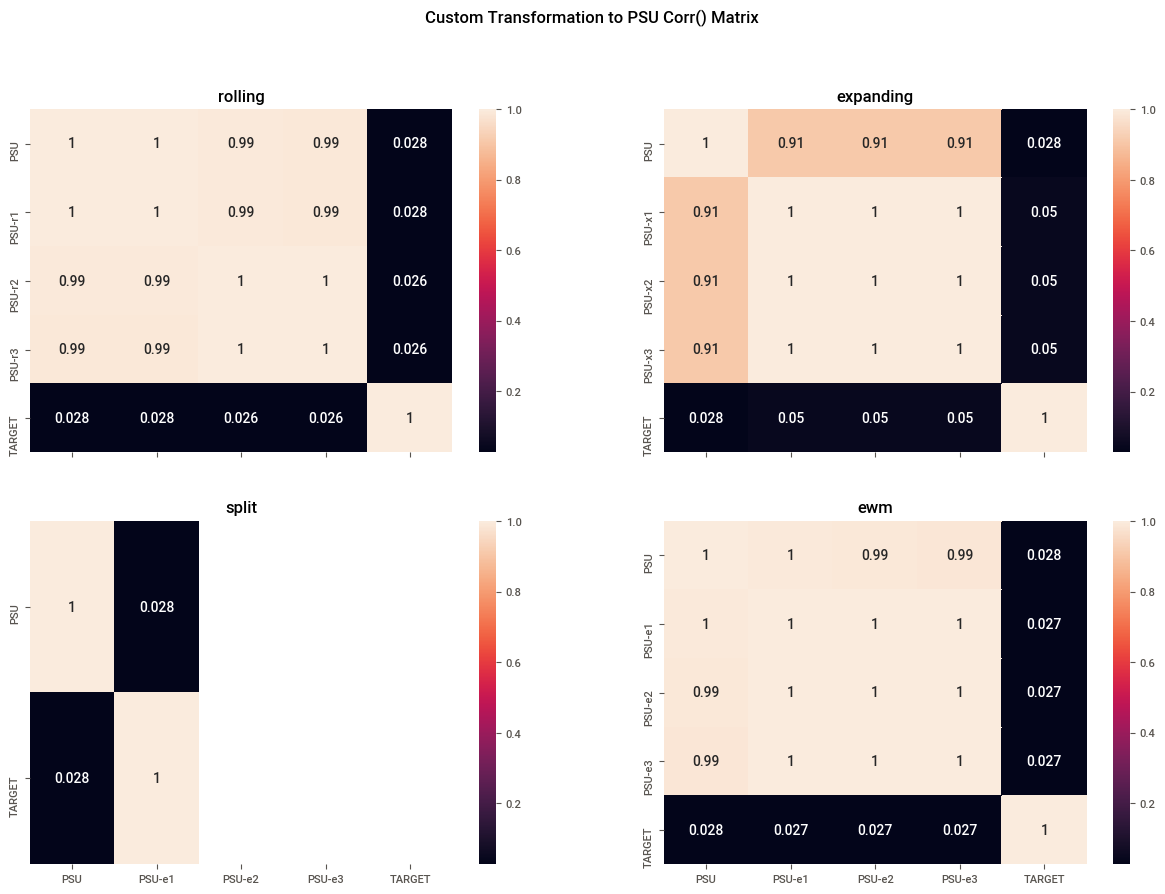

In [39]:
transformer = [ 'rolling','expanding','split','ewm']
fig, axs = plt.subplots(2, 2, figsize=(15,10), sharex=True)
fig.suptitle('Custom Transformation to PSU Corr() Matrix')
xy = [[0,0],[0,1],[1,0],[1,1]]
i=0
df_flows=df.copy()
for method in transformer:

    # Create X and y
    X = df_psu.drop('TARGET', axis=1)
    y = df_psu.TARGET

    # define columns which will passed to transformer for the grouping (brk)
    # when applying method such as shift or expanding, I want to maintain the
    # fund grouping (or other attribute to set in brk).
    brk='SRC_UID'

    # create a configuration dictionary for the transformer
    trans = []
    dico= {}
    dico['cols'] = ['PSU']
    dico['method'] = method
    dico['period'] = [1,2,3]
    dico['original'] = True
    trans.append(dico)

    # create the steps and the transformation Pipeline
    steps = [('ts_2_supervised',myt.TS2Supervised(transformation=trans, breakdown=brk
                                              , verbose=False, interpolation=True))]
    transformation_pipeline = Pipeline(steps)

    test_transformed_pipeline = transformation_pipeline.fit_transform(X, y)
    test_transformed_pipeline=test_transformed_pipeline.merge(df['TARGET'], left_index=True, right_index=True)

    net_flows_cols = [x for x in test_transformed_pipeline.columns if 'PSU' in x]
    net_flows_cols.append('TARGET')

    #plt.figure(figsize=(4,4))

    sns.heatmap(data=test_transformed_pipeline[net_flows_cols].corr(), annot=True, ax=axs[xy[i][0],xy[i][1]])
    axs[xy[i][0],xy[i][1]].set_title(method)
    i=i+1



plt.show();

# OUTLIERS

Sources:
TowardDataScience articles:
- https://towardsdatascience.com/anomaly-detection-with-isolation-forest-visualization-23cd75c281e2




In [40]:
to_model_columns=cols_flows + cols_performances + cols_marketing + cols_research
metrics_df=df.copy()

In [41]:
from sklearn.ensemble import IsolationForest
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.1), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(metrics_df[to_model_columns])
pred = clf.predict(metrics_df[to_model_columns])
metrics_df['anomaly']=pred
outliers=metrics_df.loc[metrics_df['anomaly']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(metrics_df['anomaly'].value_counts())
logging.info('Anomaly detected in full dataset')
logging.info(metrics_df['anomaly'].value_counts())

C:\Users\resqu\.conda\envs\exts-ml\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\resqu\.conda\envs\exts-ml\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


 1    8902
-1     989
Name: anomaly, dtype: int64


C:\Users\resqu\.conda\envs\exts-ml\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\resqu\.conda\envs\exts-ml\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


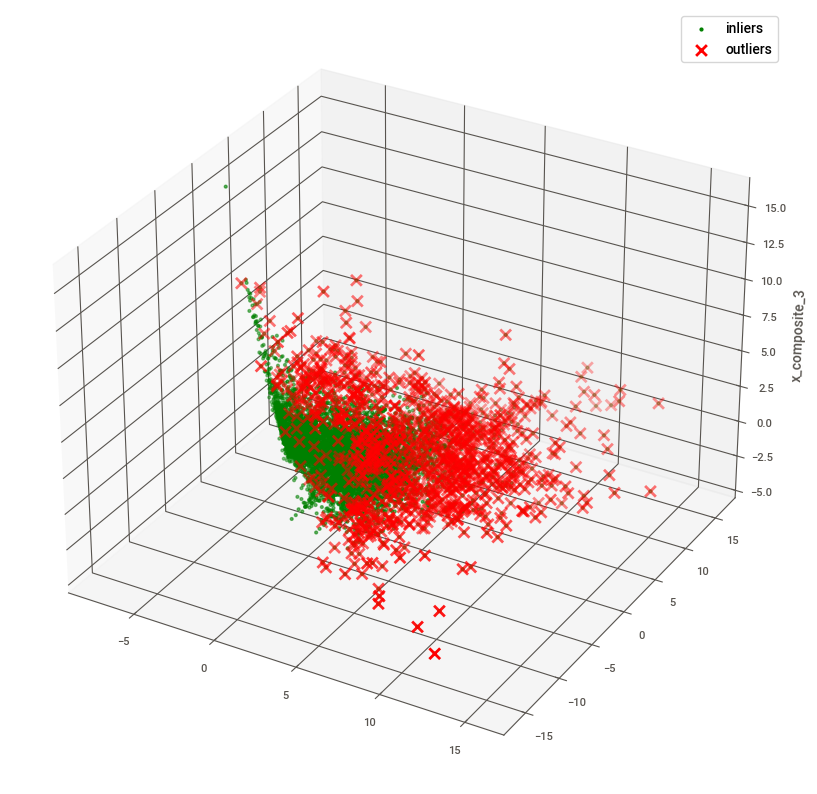

In [42]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(metrics_df[to_model_columns])
X_reduce = pca.fit_transform(X)
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

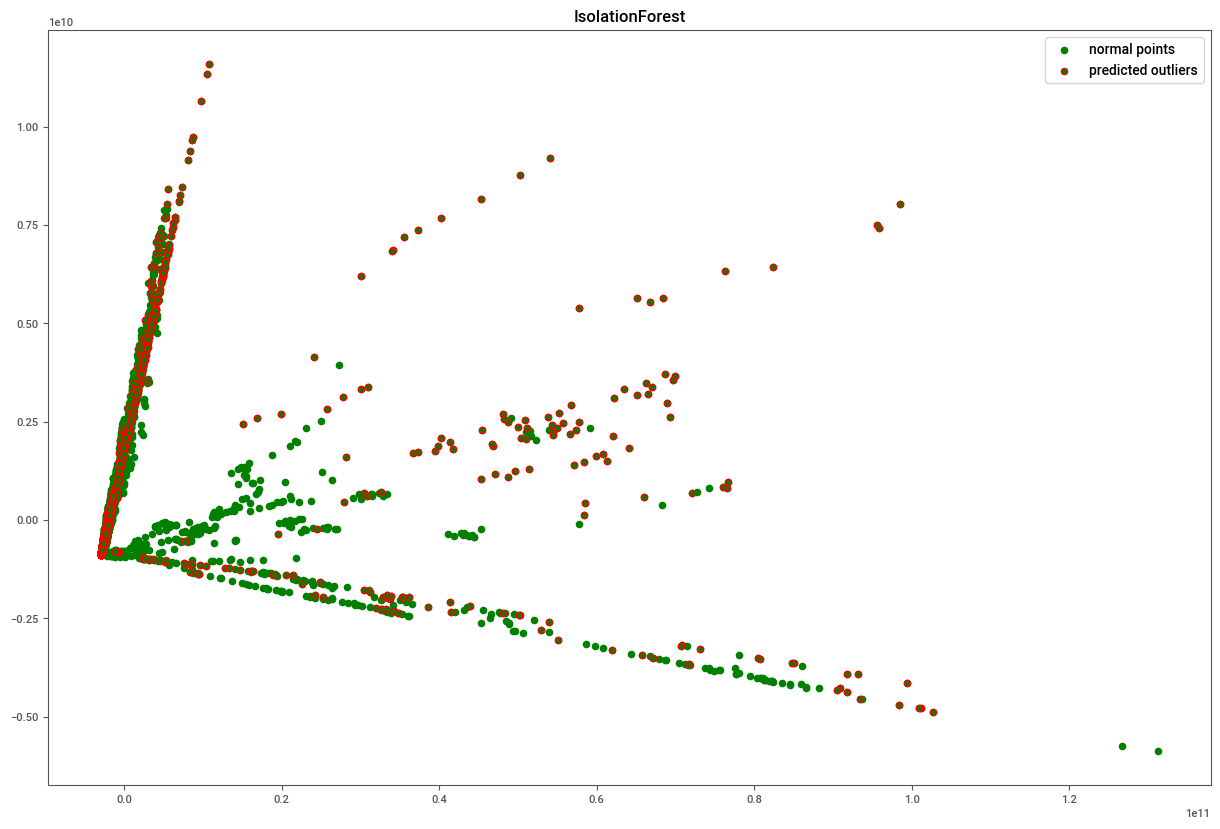

In [43]:
pca = PCA(2)
pca.fit(metrics_df[to_model_columns])
res=pd.DataFrame(pca.transform(metrics_df[to_model_columns]))
Z = np.array(res)
fig = plt.figure(figsize=(15,10))
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

In [44]:
try:
    df=df.drop(outlier_index, axis=0)
except:
    logging.warning('Unable to drop outliers from df dataset')

Save the file for the next Notebook (modeling)

In [52]:
df.to_csv(folder + 'dataset_4_modelling.csv')

## Test the transformer

To finalize this notebook, I will test the transformer on the dataset saved for modelling process by reading the config_transformation file and apply transformation.

In [46]:
# Create X and y
X = df.drop('TARGET', axis=1)
y = df.TARGET

# define columns which will passed to transformer for the grouping (brk)
# when applying method such as shift or expanding, I want to maintain the
# fund grouping (or other attribute to set in brk).

brk='SRC_UID'


# Read configuration file
try:
    with open('config_transformation.json') as data_file:
        data_loaded = json.load(data_file)
        trans = data_loaded
except:
    logging.warning('No configuration file found. Create a sample file')
    trans = []
    dico= {}
    dico['cols'] = ['NET_FLOWS']
    dico['method'] = 'shift'
    dico['period'] = [1]
    dico['original'] = True
    trans.append(dico)
    # save the config
    with open('config_transformation.json', 'w') as f:
        json.dump(trans, f)
    
# create the steps and the transformation Pipeline
steps = [('ts_2_supervised',myt.TS2Supervised(transformation=trans, breakdown=brk
                                          , verbose=False, interpolation=True))]
transformation_pipeline = Pipeline(steps)

test_transformed_pipeline = transformation_pipeline.fit_transform(X, y)

In [47]:
# merge the result transformed set witht the target value
final_df=test_transformed_pipeline.merge(y, left_index=True, right_index=True).dropna()
final_df

,SRC_UID,IS_STRATEGIC,ADMINSTRATION_FEES,MANAGEMENT_FEES,MULTI_MANAGER_STRUCTURE,EXPERIENCE,SOFTCLOSING,CNT_SHARE,QUANTITY,IN_FLOWS,...,NAV_PERF_SLOPE_ERROR,NAV_VOL_SLOPE,NAV_VOL_SLOPE_ERROR,IN_FLOWS-s1,IN_FLOWS-s2,IN_FLOWS-s3,AUM-r2,AUM-r5,AUM-r7,TARGET
0,206670688,0,2.77e-04,1.63e-03,1,0.0,0,12,5389079,69669121,...,4.77e-03,-1.54e-04,6.94e-04,6.97e+07,6.97e+07,6.97e+07,7.14e+08,6.55e+08,6.14e+08,-1
1,206670688,0,2.77e-04,1.63e-03,1,0.0,0,12,5504541,89408248,...,3.94e-03,-1.27e-04,6.52e-04,6.97e+07,6.97e+07,6.97e+07,7.14e+08,6.55e+08,6.14e+08,1
2,206670688,0,2.77e-04,1.63e-03,1,0.0,0,12,4781963,68084125,...,3.63e-03,-1.06e-04,6.47e-04,8.94e+07,6.97e+07,6.97e+07,6.74e+08,6.55e+08,6.14e+08,-1
3,206670688,0,2.77e-04,1.63e-03,1,0.0,0,12,4910848,104779215,...,2.52e-03,-8.16e-05,6.07e-04,6.81e+07,8.94e+07,6.97e+07,6.35e+08,6.55e+08,6.14e+08,1
4,206670688,0,2.77e-04,1.63e-03,1,0.0,0,12,4408949,65517596,...,1.72e-03,-6.19e-05,6.10e-04,1.05e+08,6.81e+07,8.94e+07,6.11e+08,6.55e+08,6.14e+08,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9886,213479867994200,1,3.00e-04,5.00e-03,0,0.0,0,8,4262464,8479346,...,6.04e-02,-1.29e-03,5.54e-02,2.23e+06,7.84e+06,1.43e+07,4.99e+08,4.67e+08,4.41e+08,1
9887,213479867994200,1,3.00e-04,5.00e-03,0,0.0,0,8,4496501,14776729,...,3.46e-02,-1.21e-02,7.02e-02,8.48e+06,2.23e+06,7.84e+06,5.10e+08,4.89e+08,4.68e+08,1
9888,213479867994200,1,3.00e-04,5.00e-03,0,0.0,0,8,4735747,24501245,...,5.58e-02,-3.28e-03,6.00e-02,1.48e+07,8.48e+06,2.23e+06,5.47e+08,5.17e+08,4.90e+08,1
9889,213479867994200,1,3.00e-04,5.00e-03,0,0.0,0,8,5097105,43874436,...,7.42e-02,-5.92e-03,6.24e-02,2.45e+07,1.48e+07,8.48e+06,6.06e+08,5.46e+08,5.22e+08,1


In [48]:
df.columns
logging.info('All collumns of the final dataset \n{}'.format(df.columns))

In [49]:
logging.info('END OF RUN')

In [50]:
# create the features list
features = [x for x in final_df.columns if 'x' in x or 'e' in x  or 's' in x or 'r' in x or 'SLOPE' in x]
features.append('TARGET')
features.append('FLOWS_YEAR')
features.append('FLOWS_MONTH')
# I keep the SRC_UID but I will not use it in the modeling process
features.append('SRC_UID')
logging.info('List of features selected for modeling \n{} with {} rows'.format(features, final_df.shape[0]))
features

['BENCH_PERF_SLOPE',
 'BENCH_PERF_SLOPE_ERROR',
 'BENCH_VOL_SLOPE',
 'BENCH_VOL_SLOPE_ERROR',
 'NAV_PERF_SLOPE',
 'NAV_PERF_SLOPE_ERROR',
 'NAV_VOL_SLOPE',
 'NAV_VOL_SLOPE_ERROR',
 'IN_FLOWS-s1',
 'IN_FLOWS-s2',
 'IN_FLOWS-s3',
 'AUM-r2',
 'AUM-r5',
 'AUM-r7',
 'TARGET',
 'FLOWS_YEAR',
 'FLOWS_MONTH',
 'SRC_UID']

In [55]:
# create X and y with transformed 
X = final_df[features].drop(['TARGET','SRC_UID'], axis=1)
y = final_df.TARGET

X=X.astype('float64')
y=y.astype('float64')
# split train-test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# create a pipeline for the baseline
steps = [('scaler', StandardScaler()), 
             ('tree', LogisticRegression())]
pipeline = Pipeline(steps) # define the pipeline object.
# call the pipeline and predict for test data
z = pipeline.fit(X_train, y_train)

predictions=z.predict(X_test)
# print(predictions, y_test)

# compute the score as the baseline
print('Score value after transformation is {:.4f}'.format(z.score(X_test, y_test)))

Score value after transformation is 0.4818
